# Free energy landscapes and clustering with Gaussian mixture models

## 1. Reading the data

In [1]:
import numpy as np
import GMM_FE

data = np.loadtxt('data/CaM_PCA_CA_contacts_REST.txt')


## 2. Constructing the object and setting parameters
Create a free energy and clustering object. In principle, *data*, minimum number of components, *min_n_components*, and maximum number of components, *max_n_components* need to be specified. If *max_n_components* is not specified, the free energy estimation and clustering will be done using *min_n_components* components. The settings of the necessary parameters will be printed below. If not supplied by the user when creating the object, the default values will be used. 

In [2]:
gmm_FE = GMM_FE.FreeEnergy(data, min_n_components=8, max_n_components=20, temperature=300.0, 
                            n_iterations=3, n_grids=50, n_splits=4,stack_landscapes=False)

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 4
   shuffle_data = False
   n_iterations = 3
   n_grids = 50
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[-4.8644411168558515, 10.83157794323054], [-6.875103988258936, 8.627237475799573]]
   temperature = 300.0
   min_n_components = 8
   max_n_components = 20
   n_components_step = 1
*----------------------------------------------------------------------------*


## 3. Estimating free energy landscapes

The density estimation is performed with Gaussian mixture models (GMM) and model selection.

### Gaussian mixture model
A Gaussian mixture density is a weighted sum of Gaussian components, 
$$\rho(x) = \sum\limits_{i=1}^{N_{\text{basis}}} \pi_i \mathcal{N}(x|\; \mu_i,\; \Sigma_i),$$
where $\pi_i$ is the amplitude, $\mu_i$ is the mean and $\Sigma_i$ is the covariance of the $i$th Gaussian. The amplitudes, means and covariances are here optimized iteratively with Expectation-Maximization. The expectation-maximization algorithm consists of two steps, abbreviated E-step and the M-step.

#### - E-step
In the E-step, the responsibility of each data point with respect to the Gaussian components is calculated as
$$ \gamma_{ni} = \frac{\pi_i \mathcal{N}(x_n|\; \mu_i,\; \Sigma_i)}{\sum\limits_{i=1}^{N_{\text{basis}}} \pi_i \mathcal{N}(x_n|\; \mu_i,\; \Sigma_i)}.$$

#### - M-step
The parameters are then updated in the maximization step. The amplitudes are updated with
$$\pi_i = \frac{\sum_n \gamma_{ni}}{\sum_{n,i}\gamma_{ni}},$$
the means with
$$\mu_i = \frac{\sum_n \gamma_{ni}x_n}{\sum_n \gamma_{ni}},$$
and covariances with
$$\Sigma_i = \frac{\sum_n \gamma_{ni}(x_n-\mu_i)(x_n-\mu_i)^T}{\sum_n \gamma_{ni}} .$$

These two steps are carried out until convergence of the log-likelihood, $\mathcal{l} = \sum_{n=1}^N \log (\rho(x_n))$. 

### Model selection 
To select the number of Gaussian components in the density model, we can use either $K$-fold cross-validation or Bayesian information criterion for identifying one model, or Akaike information criterion for weighting multiple models. 

#### $K$-fold cross-validation
In $K$-fold cross-validation, the data is split into $K$ folds. One chunk of the data is used for training model parameters, while the other is used for validating the trained model. In this case, model validation occurs by calculating the log-likelihood of the validation set. In $K$-fold cross-validation, each fold is used as a validation set once per model. This results in $K$ training and validation sets for each model. The total validation log-likelihood score of a model is the summed validation log-likelihoods of all validation sets. The number of folds, $K$ is set with *n_splits* in the above cell.

#### Bayesian information criterion
If *n_splits* is set to 1 when creating the object (above cell), model selection will be done with Bayesian information criterion (BIC). In short, the log-likelihood of the fitted data will increase with increased number of parameters. The BIC tries to account for this by adding a penalty for the number of parameters,
$$
BIC = \log(N) N_{param} - 2\mathcal{l}.
$$

#### Weighting multiple GMMs (stacking landscapes)
If *stacking_landscapes* is set to True, the final density model will be a weighted average of all estimated models based on the Akaike information criterion. The Bayesian information criterion (BIC) is good for selecting one model (it does so with probability one). However, for weighting models, the Aikake information criterion (AIC) is better suited. AIC follows the same idea as BIC such that complex models are penalized. However, the AIC has a slightly different formula which makes it better suited for weighting models,
$$
AIC = 2k-2\mathcal{l}.
$$
The weight of model $m$ with an AIC score of $a_m$ is then set to
$$
w_m = \frac{e^{-\frac{\Delta a_m}{2}}}{\sum \limits_{m=1}^{N_{models}} e^{-\frac{\Delta a_m}{2}}},
$$
where $\Delta a_m = a_m - min\big(\{a\}_{m=1}^{N_{models}}\big)$.

### Running the code
Calling the function *landscape()* will estimate the density and free energy landscape with Gaussian mixture models. The axes limits of the landscape are printed above. 
**This returns:**
1. *coords*: The coordinates of the grid that is used for visualization.
2. *FE_landscape*: The estimated free energy of each grid point.
3. *FE_points*: The estimated free energy of each point in *data*.

In [3]:
coords, FE_landscape, FE_points = gmm_FE.landscape()

Estimating density with GMM.
# Components = 8
# Components = 9
# Components = 10
# Components = 11
# Components = 12
# Components = 13
# Components = 14
# Components = 15
# Components = 16
# Components = 17
# Components = 18
# Components = 19
# Components = 20
Training final model with 15 components.
Evaluating density in landscape
Density grid shape: (50, 50)


## 4. Visualizing the free energy landscape
To visualize the estimated free energy landscape, we call the *visualize* function. To visualize with the standard parameter settings, it is just to run 
<br>
> **gmm_FE.visualize()**

<br> However, you might want to change some of the parameters. 
<br><br>
**The following parameters can be changed:**
1. *title*: The title of the figure
2. *fontsize*: Title fontsize, other labels are changed according to this
3. *savefig*: True/False (whether to save a .png and .eps figure)
4. *xlabel*: The x-label
5. *ylabel*: The y-label
6. *vmax*: Colormap max cutoff value.
7. *n_contour_levels*: Determines the number and positions of the contour lines / regions in contourf.
8. *show_data*: True/False (whether to scatter-plot the original data and/or clustering)

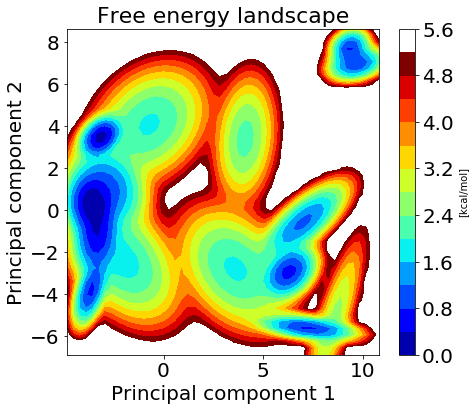

In [4]:
gmm_FE.visualize(savefig=False, vmax=5, xlabel='Principal component 1', ylabel='Principal component 2')

## 5. Cluster points at free energy minima
Using the estimated Gaussian mixture density, we can identify core states at density maxima and divide the points into clusters. Clustering the free energy landscape can be done with 
<br> 
> **gmm_FE.cluster(data, FE_points)**

<br>Recall that *FE_points* is an array with the estimated free energy of each point in *data*. To make the clustering slightly more robust, we can do it over the grid that we use for visualization and then return cluster indices of the *data* points,
> **gmm_FE.cluster(grid_points, FE_points, data)**

The grid coordinates are kept in *coords*. We also need to parse *data* as a third argument to return the cluster labels and cluster center indices of the *data* points. By default, we will get the core state clustering (core state points have cluster indices > 0, and transition points have cluster indices equal to zero). To assign cluster indices to the non-core state points (transition points), just set *assign_transition_points* to True.
<br> <br>
**This returns:**
1. *labels*: The cluster label/index of each point, denoting which cluster the point belongs to. If zero, the point is a transition point, otherwise it belongs to some intermediate state.
2. *cluster_centers*: Contains the indices corresponding to the point of each cluster that has the smallest free energy. In *return_center_coords* is set to True, this contains the coordinates of the cluster centers instead.
<br>

When the clustering is performed, new points can be assigned cluster indices based on the precomputed clustering with the function
> **gmm_FE.evaluate_clustering(new_points, assign_transition_points=False)**

In [5]:
labels, cluster_centers = gmm_FE.cluster(coords,FE_points,data, assign_transition_points=False)

Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 1340.0
Clustering data points.
Cluster labels: [ 0.  1.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
No point found in cluster 2
Done clustering.


## 6. Visualizing the free energy landscape with identified clusters

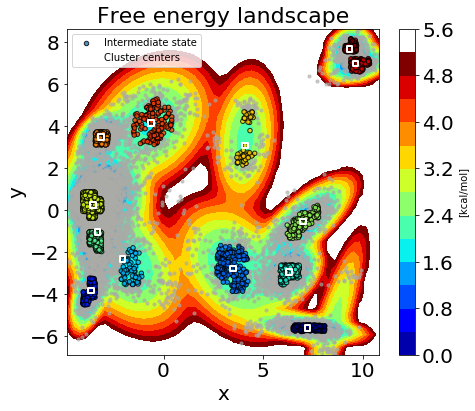

In [6]:
# Visualize free energy landscape with cluster labels
gmm_FE.visualize(savefig=True,vmax=5,show_data=True)